In [265]:
import numpy as np
import matplotlib.pyplot as plt
from profit.sur.backend.gp_functions import invert, nll, predict_f
from profit.sur.backend.kernels import kern_sqexp
from profit.util.halton import halton
from numpy.linalg import multi_dot

In [266]:
def f(x): return x*np.cos(10*x)

# Custom function to build GP matrix
def build_K(xa, xb, hyp, K):
    for i in np.arange(len(xa)):
        for j in np.arange(len(xb)):
            K[i, j] = kern_sqexp(xa[i], xb[j], hyp[0])

noise_train = 0.01

ntrain = 20
xtrain = halton(1, ntrain)
ftrain = f(xtrain)
np.random.seed(0)
ytrain = ftrain + noise_train*np.random.randn(ntrain, 1)

In [295]:
# GP regression with fixed kernel hyperparameters
hyp = [0.5, 1e-6]  # l and sig_noise**2

K = np.empty((ntrain, ntrain))   # train-train
build_K(xtrain, xtrain, hyp, K)  # writes inside K
Ky = K + hyp[-1]*np.eye(ntrain)
Kyinv = invert(Ky, 4, 1e-6)       # using gp_functions.invert

ntest = 10
xtest = np.linspace(0, 1, ntest)
ftest = f(xtest)

Ks = np.empty((ntrain, ntest))  # train-test
Kss = np.empty((ntest, ntest))  # test-test
build_K(xtrain, xtest, hyp, Ks)
build_K(xtest, xtest, hyp, Kss)

fmean = Ks.T.dot(Kyinv.dot(ytrain)) # predictive mean


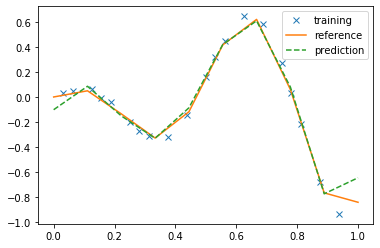

In [296]:
plt.figure()
plt.plot(xtrain, ytrain, 'x')
plt.plot(xtest, ftest, '-')
plt.plot(xtest, fmean, '--')
plt.legend(('training', 'reference', 'prediction'))

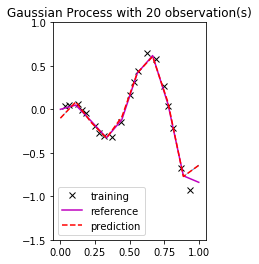

In [298]:
Ef, varf = predict_f(hyp, xtrain.reshape(-1, 1),
                      ytrain.reshape(-1, 1), xtest.reshape(-1, 1), neig=8)# posterior Estimation and variance
varf = np.diag(varf)

# we keep only the diag because the variance is on it, the other terms are covariance

plt.subplot(1, 2, 1)
plt.plot(xtrain, ytrain, 'kx')
plt.plot(xtest, ftest, 'm-')
plt.plot(xtest, fmean, 'r--')
axes = plt.gca()
axes.set_ylim([-1.5, 1])
plt.title('Gaussian Process with '+ str(ntrain) + ' observation(s)')
plt.legend(('training', 'reference', 'prediction'))



plt.fill_between(xtest, # x
                 (fmean.flatten() + 2 * np.sqrt(varf)), # y1
                 (fmean.flatten() - 2 * np.sqrt(varf))) # y2

In [299]:
# Negative log likelihood over length scale
ls = np.linspace(1e-3, 3, 50)
nlls = np.array(
    [nll([l, 0.00694534], xtrain, ytrain, 0) for l in ls]
    ).flatten()

Text(0.5, 1.0, 'Negative log-likelihood')

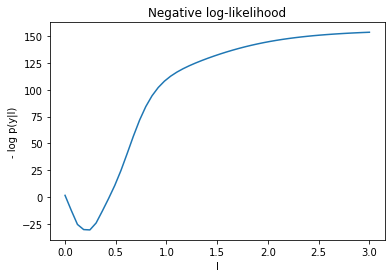

In [300]:
plt.figure()
plt.plot(ls, nlls)
plt.xlabel('l')
plt.ylabel('- log p(y|l)')
plt.title('Negative log-likelihood')

In [374]:
from scipy.optimize import minimize

def nll_transform(log10hyp):
    hyp = 10**log10hyp
    return nll(hyp, xtrain, ytrain, 0)

res = minimize(nll_transform, np.array([0, -6]), method='BFGS')

In [387]:
print(res)
print('[l,sig2] = ', 10**res.x)
hess_inv = res.hess_inv
print("\nhess_inv = ", hess_inv)

      fun: -51.35427379159095
 hess_inv: array([[0.00129113, 0.00049261],
       [0.00049261, 0.03422863]])
      jac: array([3.95774841e-05, 1.57356262e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 268
      nit: 19
     njev: 65
   status: 2
  success: False
        x: array([-0.64803431, -4.02323524])
[l,sig2] =  [2.24887695e-01 9.47904880e-05]

hess_inv =  [[0.00129113 0.00049261]
 [0.00049261 0.03422863]]


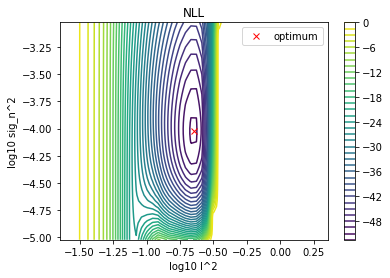

In [378]:
nl = 50
ns2 = 40

log10l = np.linspace(res.x[0]-1, res.x[0]+1, nl)
log10s2 = np.linspace(res.x[1]-1, res.x[1]+1, ns2)
[Ll, Ls2] = np.meshgrid(log10l, log10s2)

nlls = np.array(
    [nll([10**ll, 10**ls2], xtrain, ytrain, 0) for ls2 in log10s2 for ll in log10l]
    ).reshape([ns2, nl])

# Do some cut for visualization
maxval = 0.0
nlls[nlls>maxval] = maxval

plt.figure()
plt.title('NLL')
plt.contour(Ll, Ls2, nlls, levels=50)
plt.plot(res.x[0], res.x[1], 'rx')
plt.xlabel('log10 l^2')
plt.ylabel('log10 sig_n^2')
plt.colorbar()
plt.legend(['optimum'])
plt.show()

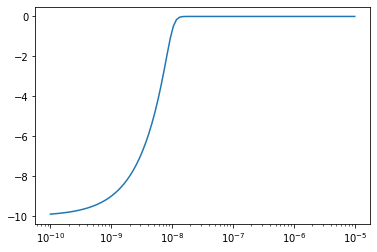

In [379]:
# Trying out priors to cut values

def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

def prior(hyp):
    return sigmoid(hyp[0]-6)*sigmoid(hyp[-1]-6)

x = np.logspace(-10, -5, 100)
plt.semilogx(x, np.log(sigmoid(1e9*x - 10)))

In [407]:

from profit.sur.backend.gp_functions import k

def dkdl(xa, xb, l): # derivative of the kernel w.r.t lengthscale
    return ((xa - xb)**2.0 * np.exp(-(xa-xb)**2.0/(2 * l**2))) / l**3


K = np.empty((ntrain, ntrain))
for i in np.arange(len(xtrain)):
    for j in np.arange(len(xtrain)):
        K[i, j] = k(xtrain[i], xtrain[j], hyp[0])


K_star = np.empty((ntest, ntrain))
for i in np.arange(len(xtest)):
    for j in np.arange(len(xtrain)):
        K_star[i, j] = k(xtest[i], xtrain[j], hyp[0])


K_prime = np.empty((ntrain, ntrain))
for i in np.arange(len(xtrain)):
    for j in np.arange(len(xtrain)):
        K_prime[i, j] = dkdl(xtrain[i], xtrain[j], hyp[0])


K_star_prime = np.empty((ntest, ntrain))
for i in np.arange(len(xtest)):
    for j in np.arange(len(xtrain)):
        K_star_prime[i, j] = dkdl(xtest[i], xtrain[j], hyp[0])

# K.shape = (20, 20)
# K_prime.shape = (20, 20)

# K_star.shape = (10, 20)
# K_star_prime.shape = (10, 20)

In [408]:






alpha = np.dot(Kyinv, ytrain) # RW p17 paragraph 4

dalpha_dl = -Kyinv.dot(K_prime)\
    .dot(Kyinv)\
    .dot(ytrain)

dalpha_ds = -Kyinv.dot(np.eye(ntrain)).dot(Kyinv).dot(ytrain) # - Kyinv x I x Kyinv x ytrain 

dm = np.empty((ntest,len(hyp), 1))

for nb_hyp in range(len(hyp)):
    if nb_hyp == 0 :
        dm[:,nb_hyp,:] = np.dot(K_star_prime, alpha) -\
                         np.dot(K_star, dalpha_dl) 
    else : 
        dm[:,nb_hyp,:] = np.dot(K_star, dalpha_ds)

print("\n\n\ndm :",dm.shape, "\n\n")
print(dm)

    







dm : (10, 2, 1) 


[[[-4.36131755e+01]
  [-4.45847918e+04]]

 [[-3.73312284e+01]
  [ 1.12339723e+04]]

 [[ 5.21937486e+00]
  [-7.57721168e+03]]

 [[ 3.68606896e+01]
  [-2.13485122e+03]]

 [[ 2.38631202e+01]
  [ 1.04324707e+04]]

 [[-2.49745289e+01]
  [ 9.14886688e+02]]

 [[-6.12473712e+01]
  [-1.29530049e+04]]

 [[-3.26992972e+01]
  [ 8.25762798e+02]]

 [[ 7.35281069e+01]
  [ 1.27342497e+04]]

 [[ 2.12791582e+02]
  [-9.68239449e+04]]]


In [409]:
sigma = invert(hess_inv) # define the sigma matrix as the inverse of hess_inv
V = varf # set V as the result of the predict_f diagonal  

print("\nsigma shape : ", sigma.shape)
print(sigma)
print("dm.shape : ", dm.shape)



dm_transpose = np.empty((ntest, 1, len(hyp)))
dmT_dot_sigma = np.empty((ntest, 1, len(hyp)))
dmT_dot_sigma_dot_dm = np.empty((ntest, 1))



for i in range(ntest):
    dm_transpose[i] = dm[i].T
    print("\n\ndm.t",i,' : ', dm_transpose[i])
    dmT_dot_sigma[i] = dm_transpose[i].dot(sigma)
    print("dmT_dot_sigma",i," : ",dmT_dot_sigma[i])
    dmT_dot_sigma_dot_dm[i] = dmT_dot_sigma[i].dot(dm[i])
    print("dmT_dot_sigma_dot_dm",i," : ", dmT_dot_sigma_dot_dm[i])
    
print("dm_transpose :", dm_transpose.shape)
print("\ndmT_dot_sigma ", test.shape)
print("dmT_dot_sigma_dot_dm ", dmT_dot_sigma_dot_dm.shape)
print("V ", V.shape)


 
V_tild = V.reshape((ntest,1)) + dmT_dot_sigma_dot_dm # Osborne et al. (2012) Active learning eq.19 


print("V_tild.shape ", V_tild.shape)
print("\n\n\tMarginal variance\n\n", V_tild)





sigma shape :  (2, 2)
[[778.79414511 -11.20816998]
 [-11.20816998  29.37661016]]
dm.shape :  (10, 2, 1)


dm.t 0  :  [[-4.36131755e+01 -4.45847918e+04]]
dmT_dot_sigma 0  :  [[  465748.23904047 -1309261.22278424]]
dmT_dot_sigma_dot_dm 0  :  [5.83528262e+10]


dm.t 1  :  [[  -37.33122835 11233.97226906]]
dmT_dot_sigma 1  :  [[-154985.61282844  330434.43860014]]
dmT_dot_sigma_dot_dm 1  :  [3.71787712e+09]


dm.t 2  :  [[ 5.21937486e+00 -7.57721168e+03]]
dmT_dot_sigma 2  :  [[  88991.49511577 -222651.29332678]]
dmT_dot_sigma_dot_dm 2  :  [1.68754046e+09]


dm.t 3  :  [[   36.86068962 -2134.85121918]]
dmT_dot_sigma 3  :  [[ 52634.66461258 -63127.83288095]]
dmT_dot_sigma_dot_dm 3  :  [1.36708681e+08]


dm.t 4  :  [[   23.8631202  10432.47071457]]
dmT_dot_sigma 4  :  [[-98344.44679671 306203.16323428]]
dmT_dot_sigma_dot_dm 4  :  [3.19210873e+09]


dm.t 5  :  [[-24.97452891 914.88668823]]
dmT_dot_sigma 5  :  [[-29704.22240629  27156.18834198]]
dmT_dot_sigma_dot_dm 5  :  [25586684.17840312]


